In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets,transforms,models
from torchvision.transforms.transforms import ToPILImage
import os
import cv2
import torch.optim as optim
from PIL import ImageFile,Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn.modules.dropout import Dropout
import itertools
from google.colab.patches import cv2_imshow
from torchsummary import summary

In [ ]:
resize = (224,224)
batch_size = 32

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

torch.manual_seed(1212)
np.random.seed(1212)

In [ ]:
classes = ['COVID','Normal','Pneu-Bac','Pneu-Viral']

**Image Transform**

In [ ]:
img_transform = {
    'train':transforms.Compose([
                                transforms.Resize(resize),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean,std)
    ]),
    'val':transforms.Compose([
                              transforms.Resize(resize),
                              transforms.CenterCrop(resize),
                              transforms.ToTensor(),
                              transforms.Normalize(mean,std)
    ]),
    'test':transforms.Compose([
                               transforms.Resize(resize),
                               transforms.ToTensor(),
                               transforms.Normalize(mean,std)
    ])
}

**Datasets**

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/train'
val_path = '/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/valid'
test_path = '/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/split_data/test'

In [ ]:
train_count = len(glob.glob(train_path+'/**/*.jpg'))
val_count = len(glob.glob(val_path+'/**/*.jpg'))
test_count = len(glob.glob(val_path+'/**/*.jpg'))
print(train_count,val_count,test_count)

5526 1841 1841


In [ ]:
#datasets
train_file = datasets.ImageFolder(train_path,transform=img_transform['train'])
val_file = datasets.ImageFolder(val_path,transform=img_transform['val'])
test_file = datasets.ImageFolder(test_path,transform=img_transform['test'])

**Dataloader**

In [ ]:
loader = {
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'val':torch.utils.data.DataLoader(val_file,batch_size,shuffle=False),
    'test':torch.utils.data.DataLoader(test_file,batch_size,shuffle=False)
}

**Load checkpoint model**

In [3]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/COVID-LVTN/cnn-checkpoint/checkpoint_cnn_3.pt',map_location='cpu')
#CNN Network
class Net(nn.Module):
  def __init__(self,num_classes):
    super(Net,self).__init__()
    
    self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
 
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
 
            nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

 
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
 
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
 
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
 
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)  
        )
  

  def forward(self,xb):
    return self.network(xb)

model = Net(num_classes=4)
model.load_state_dict(checkpoint['model_state_dict']);
model.eval();

**Loss & Optimizer**

In [ ]:
#loss
criterior = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

**Test model**

In [ ]:
model.eval()
test_loss = 0.0
test_acc = 0.0
preds = []
targets = []

for inputs,labels in tqdm(loader['test']):
  outputs = model(inputs)
  loss = criterior(outputs,labels)
  test_loss += loss.cpu().data*inputs.size(0)

  _,prediction = torch.max(outputs.data,1)
  preds.append(prediction)
  targets.append(labels)

  test_acc += torch.sum(prediction==labels.data)

test_acc = test_acc/test_count
print("Test Accuracy: {:.4f}".format(test_acc))

100%|██████████| 58/58 [02:23<00:00,  2.47s/it]

Test Accuracy: 0.8479


In [ ]:
#converting the tensor object to a list for metric functions
preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

In [ ]:
#Computing accuracy
acc = accuracy_score(targets2,preds2)
print('Accuracy:',acc)

Accuracy: 0.8479087452471483


**Confusion matrix**

In [ ]:
cm = confusion_matrix(targets2,preds2)
print(cm)

[[247   4   5   0]
 [  1 650   1   2]
 [  1  60 517  22]
 [  1  72 111 147]]


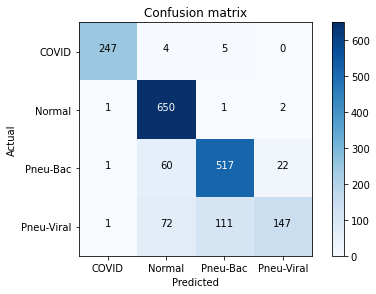

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plot_confusion_matrix(cm,classes)

**Classification report**

In [ ]:
print('Classification Report\n---------------------')
print(classification_report(targets2,preds2))

Classification Report
---------------------
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       256
           1       0.83      0.99      0.90       654
           2       0.82      0.86      0.84       600
           3       0.86      0.44      0.59       331

    accuracy                           0.85      1841
   macro avg       0.87      0.82      0.83      1841
weighted avg       0.85      0.85      0.83      1841



**Loss & Accuracy plot**

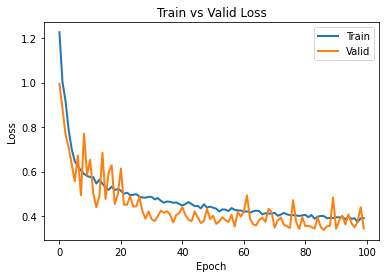

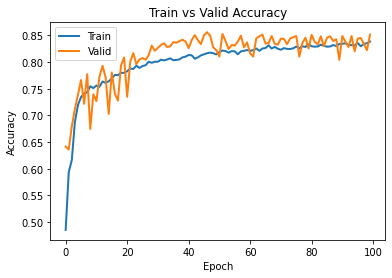

In [ ]:
#Load checkpoint
train_losses = checkpoint['train_losses']
train_accu = checkpoint['train_accu']
val_losses = checkpoint['val_losses']
val_accu = checkpoint['val_accu']

#Plot loss
plt.plot(train_losses,linewidth=2)
plt.plot(val_losses,linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.show()

#Plot accuracy
plt.plot(train_accu,linewidth=2)
plt.plot(val_accu,linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
plt.show()

In [ ]:
max_accu = max(val_accu)
idx = val_accu.index(max_accu)
print(idx,max_accu,val_losses[idx])

46 tensor(0.8561) tensor(0.3690)


**Prediction image**

In [ ]:
def predicton(img_path,transformer):
  #load image
  img = cv2.imread(img_path)
  cv2.cvtColor(img,cv2.COLOR_BGR2RGB)   #mặc định của matplotlib là RGB
  plt.imshow(img)
  plt.show()

  img = transforms.ToPILImage()(img)
  img_tensor = transformer(img)
  img_tensor = img_tensor.unsqueeze_(0)
 
  #Predict img 
  output = model(img_tensor)
  _,prediction=torch.max(output.data,1)
  label_pred = classes[prediction]
  
  return label_pred

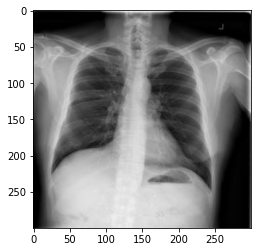

		 COVID


In [ ]:
img_path = '/content/drive/MyDrive/Colab Notebooks/COVID19/data/valid/normal/01750.jpg'
label_pred = predicton(img_path,img_transform['test'])
print('\t\t',label_pred)

In [ ]:
summary(model,(3,224,224),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,928
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
      BatchNorm2d-14          [-1, 128,